In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler

In [2]:
from preprocessing.getdata import *
df_o = get_csvdata()
df_a = get_csvdata_ADNI()

for ID in ['013_S_1275', '099_S_0533', '123_S_0050', '131_S_0457', '137_S_0796']:
    df_a = df_a[df_a['ID']!=ID]

df_a['CDR'] = df_a['label'].astype(int)



In [3]:
data_a = get_3D_data_ADNI2(df_a['ID'])
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(data_a, df_a['CDR'], stratify = df_a['CDR'], random_state=42)
del data_a

data_o = get_3D_data(df_o['ID'])
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data_o, df_o['CDR'], stratify = df_o['CDR'], random_state=42)
del data_o

X_train_o = X_train_o.astype(np.float16)/X_train_o.max()
X_train_o = (X_train_o*255).astype(np.uint8)

X_train = np.concatenate((X_train_o, X_train_a), axis=0)
X_test = np.concatenate((X_test_o, X_test_a), axis=0)

y_train = np.concatenate((y_train_o, y_train_a))
y_test = np.concatenate((y_test_o, y_test_a))

X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))

del X_train_a
del X_test_a
del X_train_o
del X_test_o

In [3]:
data_o = get_3D_data(df_o['ID'])
X_train, X_test, y_train, y_test = train_test_split(data_o, df_o['CDR'], stratify = df_o['CDR'], random_state=42)
del data_o

X_train = X_train.astype(np.float16)/X_train.max()

X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))

In [5]:
#X_train = X_train.astype(np.float16)/X_train.max()
#X_test = X_test.astype(np.float16)/X_train.max()

In [4]:
model = SVC()#C=10, gamma=10, kernel='rbf')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
accuracy_score(y_train, model.predict(X_train))

0.5


0.75

In [4]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [10]:
#X_train = X_train.astype(np.float32)
#X_test = X_test.astype(np.float32)

In [11]:
X_train.dtype

dtype('float32')

In [6]:
#pca = IncrementalPCA(batch_size=10)
pca = PCA(n_components=1000)#, svd_solver='randomized')
pca.fit(X_train)

ValueError: n_components=1000 must be between 0 and min(n_samples, n_features)=136 with svd_solver='full'

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

MemoryError: Unable to allocate 21.7 GiB for an array with shape (453, 6443008) and data type float64

In [14]:
X_train.shape

(453, 6443008)

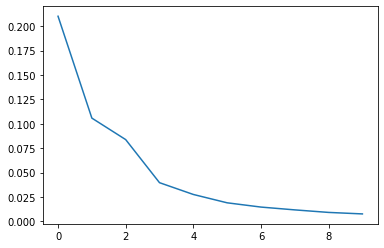

In [13]:
plt.plot(pca.explained_variance_ratio_)

In [7]:
model = SVC()#C=10, gamma=10, kernel='rbf')
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(acc)
accuracy_score(y_train, model.predict(X_train_pca))

0.5434782608695652


1.0

In [8]:
print(X_train.shape)
print(X_train_pca.shape)

(136, 6443008)
(136, 136)


In [9]:
param_grid = {'C': [0.1,1, 10, 100], 
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}

gs = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_pca, y_train)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}

In [10]:
model = gs.best_estimator_

In [11]:
y_pred = model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(acc)
accuracy_score(y_train, model.predict(X_train_pca))

0.6086956521739131


0.4852941176470588

accuracy:  0.61
recall:  0.74
precision:  0.59


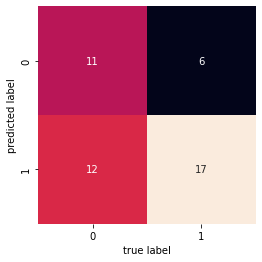

In [12]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred).round(2))
print('recall: ' , recall_score(y_test, y_pred).round(2))
print('precision: ' , precision_score(y_test, y_pred).round(2))